In [1]:
# Import Libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

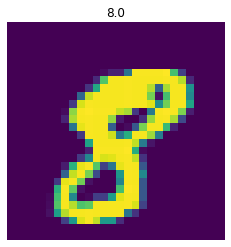

In [2]:
# Prepare Dataset
# load data
train = pd.read_csv(r"./MNIST/train.csv", dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
y_numpy = train.label.values
X_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
X_train, X_test, y_train, y_test = train_test_split(X_numpy,
                                                    y_numpy,
                                                    test_size = 0.2,
                                                    random_state = 42) 

# TENSORS NOT DATA LOADERS
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(X_train)
targetsTrain = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(X_test)
targetsTest = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(X_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(y_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [6]:
# Declaring the model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        #Layer
         
        # Convolution 1 
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, \
                             kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, \
                             kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10)

        # From ann
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.tanh2 = nn.Tanh()
#         self.fc3 = nn.Linear(hidden_dim, output_dim)
#         self.elu3 = nn.ELU()
    
    def forward(self, x):
        # From ann
#         out = self.fc1(x)
#         out = self.relu1(out)
#         out = self.fc2(out)
#         out = self.tanh2(out)
#         out = self.fc3(out)
#         out = self.elu3(out)
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        # Important! After maxpool we have 2d array, we need
        # to make a 1d array from it...
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


# Instantiate Model Class



model = CNNModel()

# Optimization paramters
criterion = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [7]:
print(model)

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


In [8]:
# Training the model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calulate softmax and cross entropy loss
        loss = criterion(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        
        # Prediction and statistics
        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Predict *test* dataset
            for images, labels in test_loader:
                test = Variable(images.view(100,1,28,28))
                
                #Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print loss
            print("Iteration: {} Loss: {} Accuracy: {}%".format(count, loss.data, accuracy))
                

Iteration: 500 Loss: 0.12160765379667282 Accuracy: 96.36904907226562%
Iteration: 1000 Loss: 0.05963285267353058 Accuracy: 97.57142639160156%
Iteration: 1500 Loss: 0.04105548560619354 Accuracy: 97.70237731933594%
Iteration: 2000 Loss: 0.015354824252426624 Accuracy: 98.26190185546875%


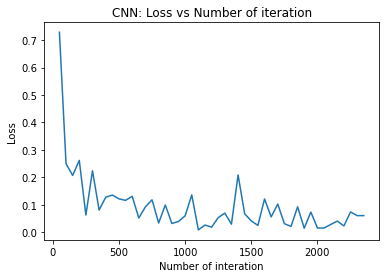

In [9]:
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of interation")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

In [15]:
# Additional - Testing model on test.csv

In [10]:
test = pd.read_csv(r"./MNIST/test.csv", dtype = np.float32)

features_numpy = test.loc[:,test.columns != "label"].values/255 # normalization

featuresFinalTest = torch.from_numpy(features_numpy)

final_loader = torch.utils.data.DataLoader(featuresFinalTest, batch_size=1, shuffle=False)

In [19]:
# Predicting...

res = []

for image in final_loader:
    test = Variable(image.view(1, 1, 28,28))
    prediction = torch.max(model(test),1)[1]
    res.append(int(prediction))

In [20]:
# Getting data conservated

ImageID = [x for x in range(1,len(res)+1)]
d = {"ImageId": ImageID, "Label":res}

df = pd.DataFrame(data = d)
df.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [21]:
# Exporting to csv...
df.to_csv("CNNMnistPrediction1.csv", index=False)

In [22]:
print(model)

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)
